# Testing the Approximate Sampling

## Importing the Packages

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [32]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [33]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Creating Test Data

In [34]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [35]:
# Time resolution
time_bin = 0.005

### True Filter

In [36]:
# True variance
sigma_f = 5.0

# True ell
ell_f = 0.5

# Time horizon
fmaxt = 10.0

# Time points for filter
d = np.floor(fmaxt/time_bin).astype(np.int64) 
ftime = np.linspace(0.0, fmaxt, d + 1).reshape((d + 1, 1))

# True covariance matrix
true_cov = Squared_exp(ftime, ftime.T, sigma_f, ell_f)
true_chol = np.linalg.cholesky(true_cov + 1e-6 * np.eye(d + 1))

# Sampling filter
ftrue = true_chol @ random.normal(subkeys[-1], ((d + 1, 1)))

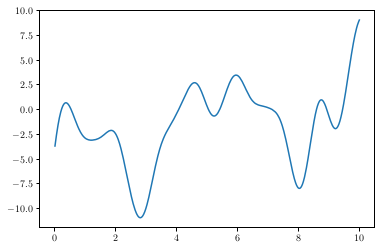

In [37]:
plt.plot(ftime, ftrue)

## Sampling Filter

### Add Noise

In [38]:
# Noise variance
sigma_n = 0.5
noise_vec = random.normal(subkeys[-2], (d + 1, 1)) * sigma_n
yobs = ftrue + noise_vec

In [80]:
# Number of samples
num_sam = 4

# Window for sampling
lower = int((d + 1) / 6)
upper = int(5 * (d + 1) / 6)
if upper - lower > num_sam:
  indices = np.arange(lower, upper)
  ind_arr = random.choice(subkeys[-2], indices, (num_sam,))
else:
  print('More samples than available in region defined. ' + str(upper - lower) + ' available.')

In [81]:
fsamp = yobs[ind_arr]
samp_t = ftime[ind_arr,:]

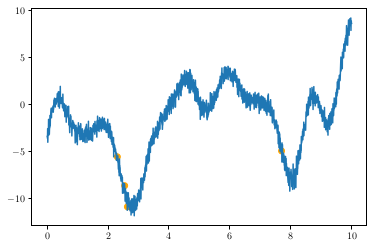

In [82]:
plt.plot(ftime, yobs)
plt.scatter(samp_t, fsamp, c = 'orange')

In [83]:
# True posterior
kastn = Squared_exp(ftime, samp_t.T, sigma_f, ell_f)
knn = Squared_exp(samp_t, samp_t.T, sigma_f, ell_f)
kastast = Squared_exp(ftime, ftime, sigma_f, ell_f)

# Posterior mean
post_mean = kastn @ sc.linalg.solve(knn + sigma_n ** 2.0 * np.eye(num_sam) + 1e-6 * np.eye(num_sam), fsamp)

# Posterior variance
post_cov = kastast - kastn @ sc.linalg.solve(knn + sigma_n ** 2.0 * np.eye(num_sam) + 1e-6 * np.eye(num_sam), kastn.T)

trues2 = np.sqrt(np.diag(post_cov))

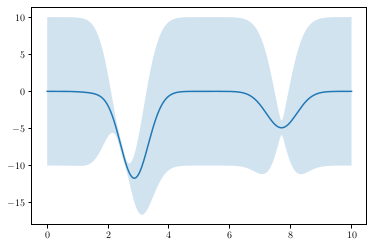

In [84]:
post_fill = (post_mean.flatten() - 2 * trues2, post_mean.flatten() + 2 * trues2)
plt.plot(ftime, post_mean)
plt.fill_between(ftime.flatten(), *post_fill, alpha = 0.2)

## Approximate Sampling

In [85]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [86]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [87]:
@partial(jit, static_argnums = range(5,8))
def Expected_Term(Sigma_f, Ell, Samp_T, Y_Samples, Sigma_n, Number_F, Num_Base, Num_Sam, F_Time, Subkeys):

  Thetas = random.multivariate_normal(Subkeys[0], jnp.zeros((1, 1, Num_Base)), (1 / (Ell ** 2)) * jnp.eye(Num_Base))

  Taus = random.uniform(Subkeys[1], (1, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Num_Base, 1))

  Constant = Sigma_f * jnp.sqrt(2.0 / Num_Base)

  ST = Samp_T.T
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Samp_T * Thetas + Taus)

  Knn = Squared_exp(Samp_T, ST, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ST, Sigma_f, Ell)

  F_Samps = Phi2 @ Omegas

  Vu = V_Solver(Knn + Sigma_n ** 2.0 * jnp.eye(Num_Sam) + 1e-6 * jnp.eye(Num_Sam), Y_Samples - F_Samps \
                                                      - random.normal(Subkeys[4], (Number_F, Num_Sam, 1)) * Sigma_n)

  F_Samples = Phi1 @ Omegas + Knm @ Vu
  
  return F_Samples, jnp.mean(Phi2 @ jnp.transpose(Phi2, (0, 2, 1)), axis = 0)

In [110]:
test_num_f = 10000
test_num_b = 10000
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 6)

In [89]:
pred_horz = 12.0

d2 = np.floor(2 * fmaxt/time_bin).astype(np.int64) 
ftimepred = np.linspace(0.0, pred_horz, d2 + 1).reshape((d2 + 1, 1))
ftimepred = ftime.copy()

In [90]:
tst = []
for b in np.linspace(1, 1000, 100).astype(np.int64):
  fsamples, cov_guess = Expected_Term(sigma_f, ell_f, samp_t, fsamp, sigma_n, test_num_f, b, num_sam, ftimepred, test_subkeys)
  # stds = np.std(fsamples, 0)
  # mean = np.mean(fsamples, 0)
  tst.append(np.sqrt(np.mean((cov_guess - Squared_exp(samp_t, samp_t.T, sigma_f, ell_f)) ** 2)))

KeyboardInterrupt: 

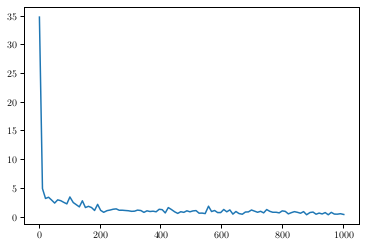

In [ ]:
plt.plot(np.linspace(1, 1000, 100).astype(np.int64), tst)

In [91]:
fsamples, cov_guess = Expected_Term(sigma_f, ell_f, samp_t, fsamp, sigma_n, test_num_f, test_num_b, num_sam, ftimepred, test_subkeys)

In [92]:
print(np.sqrt(np.mean((cov_guess - Squared_exp(samp_t, samp_t.T, sigma_f, ell_f)) ** 2)))

0.1909199158295228


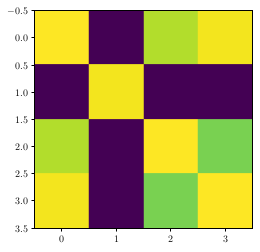

In [93]:
plt.imshow(cov_guess)

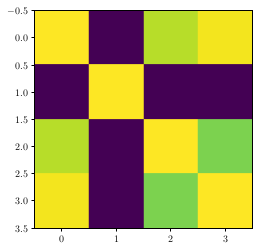

In [94]:
plt.imshow(Squared_exp(samp_t, samp_t.T, sigma_f, ell_f))

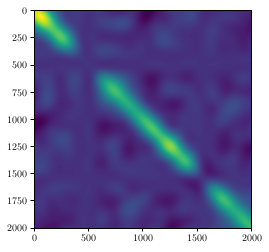

In [95]:
plt.imshow(np.cov(fsamples.reshape(100, ftimepred.shape[0]).T))

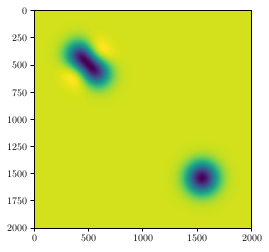

In [96]:
plt.imshow(post_cov)

In [97]:
print(cov_guess)

[[25.06466395  0.25821893 22.23379566 24.65384517]
 [ 0.25821893 24.61559797  0.22484705  0.29185906]
 [22.23379566  0.22484705 24.98535769 20.03008373]
 [24.65384517  0.29185906 20.03008373 25.06279139]]


In [98]:
print(Squared_exp(samp_t, samp_t.T, sigma_f, ell_f))

[[2.50000000e+01 2.07030900e-22 2.22796972e+01 2.45982629e+01]
 [2.07030900e-22 2.50000000e+01 1.30848248e-24 1.30305666e-21]
 [2.22796972e+01 1.30848248e-24 2.50000000e+01 2.01071571e+01]
 [2.45982629e+01 1.30305666e-21 2.01071571e+01 2.50000000e+01]]


## Prediction Posterior

In [99]:
ftimepred = np.linspace(-7.0, 20, 1000).reshape(1000, 1)

In [100]:
# True posterior
kastn = Squared_exp(ftimepred, samp_t.T, sigma_f, ell_f)
knn = Squared_exp(samp_t, samp_t.T, sigma_f, ell_f)
kastast = Squared_exp(ftimepred, ftimepred, sigma_f, ell_f)

# Posterior mean
post_mean = kastn @ sc.linalg.solve(knn + sigma_n ** 2.0 * np.eye(num_sam) + 1e-6 * np.eye(num_sam), fsamp)

# Posterior variance
post_cov = kastast - kastn @ sc.linalg.solve(knn + sigma_n ** 2.0 * np.eye(num_sam) + 1e-6 * np.eye(num_sam), kastn.T)

trues2 = np.sqrt(np.diag(post_cov))

In [101]:
post_fill = (post_mean.flatten() - 2 * trues2, post_mean.flatten() + 2 * trues2)

In [111]:
fsamples, cov_guess = Expected_Term(sigma_f, ell_f, samp_t, fsamp, sigma_n, test_num_f, test_num_b, num_sam, ftimepred, test_subkeys)

In [112]:
fsamples.shape

(10000, 1000, 1)

In [114]:
samvar = np.std(fsamples, axis = 0)
samean = np.mean(fsamples, axis = 0)

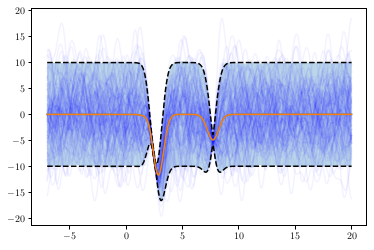

In [116]:
for i in range(test_num_f // 100):
  plt.plot(ftimepred, fsamples[100 * i], c = 'b', alpha = 0.05)
pred_fill = (samean.flatten() - 2*samvar.flatten(), samean.flatten() + 2*samvar.flatten())
plt.plot(ftimepred, post_mean)
plt.plot(ftimepred, post_fill[0], c = 'k', linestyle = '--')
plt.plot(ftimepred, post_fill[1], c = 'k', linestyle = '--')
plt.fill_between(ftimepred.flatten(), *pred_fill, alpha = 0.3)
plt.plot(ftimepred, post_mean)
#plt.fill_between(ftime.flatten(), *fill_true, alpha = 0.15, color = 'blue')
# plt.plot(ftime, muast, c = 'k')
# plt.plot(ftime, fill[0], c = 'k', linestyle = '--')
# plt.plot(ftime, fill[1], c = 'k', linestyle = '--')
# fillemp = (mean.flatten() - 2 * stds.flatten(), mean.flatten() + 2 * stds.flatten())
# plt.fill_between(ftime.flatten(), *fillemp, alpha = 0.15, color = 'blue')
# plt.scatter(z_vector, m, zorder = 3, color = 'k', marker = '*', s = 50)
#plt.ylim([-2.75, 2.4])

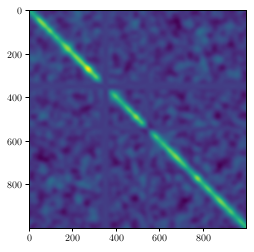

In [106]:
plt.imshow(np.cov(fsamples.reshape(100, 1000).T))

In [107]:
print(np.cov(fsamples.reshape(100, 1000).T))

[[20.04055981 19.98609593 19.85982509 ... -0.68323776 -0.70112739
  -0.70653434]
 [19.98609593 20.01765589 19.97632142 ... -1.05980672 -1.07779897
  -1.08268239]
 [19.85982509 19.97632142 20.01943975 ... -1.42880228 -1.44635942
  -1.45022465]
 ...
 [-0.68323776 -1.05980672 -1.42880228 ... 24.24128991 24.37110686
  24.43668178]
 [-0.70112739 -1.07779897 -1.44635942 ... 24.37110686 24.5762103
  24.71646424]
 [-0.70653434 -1.08268239 -1.45022465 ... 24.43668178 24.71646424
  24.9314476 ]]


In [108]:
print(knn)

[[2.50000000e+01 2.07030900e-22 2.22796972e+01 2.45982629e+01]
 [2.07030900e-22 2.50000000e+01 1.30848248e-24 1.30305666e-21]
 [2.22796972e+01 1.30848248e-24 2.50000000e+01 2.01071571e+01]
 [2.45982629e+01 1.30305666e-21 2.01071571e+01 2.50000000e+01]]


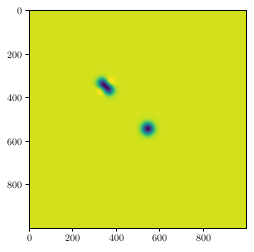

In [109]:
plt.imshow(post_cov)